# Analyse des sessions

On va s'intéresser dans cette section à l'historique des activités (sessions) des utilisateurs. 

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rnd
from tools.pca import PCA
from tools.clustering import kmeans
plt.style.use('seaborn')

In [112]:
users = pd.read_csv('data/train_users_2.csv')
test_users = pd.read_csv('data/test_users.csv')
sessions = pd.read_csv('data/sessions.csv')
countries = pd.read_csv('data/countries.csv')

users['found_destination'] = users.apply(lambda r: 'DF' if r['country_destination'] != 'NDF' else 'NDF', axis=1)
users = users.merge(countries, on='country_destination', how='left')

On a vu, dans l'introduction, qu'on ne dispose pas des sessions de tous les utilisateurs. De ce fait, on va sélectioner les utilisateurs qui ont une session avant d'équilibrer les classes (DF/NDF).

In [113]:
# Extract user ids who have sessions
base_user_ids = sessions['user_id'].unique()
base_user_ids = base_user_ids.tolist()
base_user_ids.remove(np.nan)

# Remove user ids who are from the test set
test_user_ids = test_users['id'].values
base_user_ids = list(set(base_user_ids) - set(test_user_ids))

# Select sessions with the remaining ids
users_by_ids = users.set_index('id')
session_users = users_by_ids.loc[base_user_ids]

# Balance DF and NDF labels
session_users_ndf = session_users[session_users['found_destination'] == 'NDF'].head(20000)
session_users_df = session_users[session_users['found_destination'] == 'DF'].head(20000)
session_users = pd.concat([session_users_ndf, session_users_df])
sessions = sessions[sessions['user_id'].isin(session_users.index)]

# Add column found_destination {DF, NDF}
sessions = sessions.merge(users.rename({"id":"user_id"}, axis=1)[['found_destination', 'country_destination', 'user_id']], on='user_id', how='inner')

print(f'sessions.shape : {sessions.shape}')  # One user is represented in many rows since one user can do many actions
sessions.head()

sessions.shape : (3097050, 8)


,user_id,action,action_type,action_detail,device_type,secs_elapsed,found_destination,country_destination
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0,DF,other
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0,DF,other
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0,DF,other
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0,DF,other
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0,DF,other


On a 20000 + 20000 utilisateurs DF et NDF.

## Temps écoulé

Affichons le temps que les utilisateurs ont passé sur le site (somme du temps écoulé par activités).

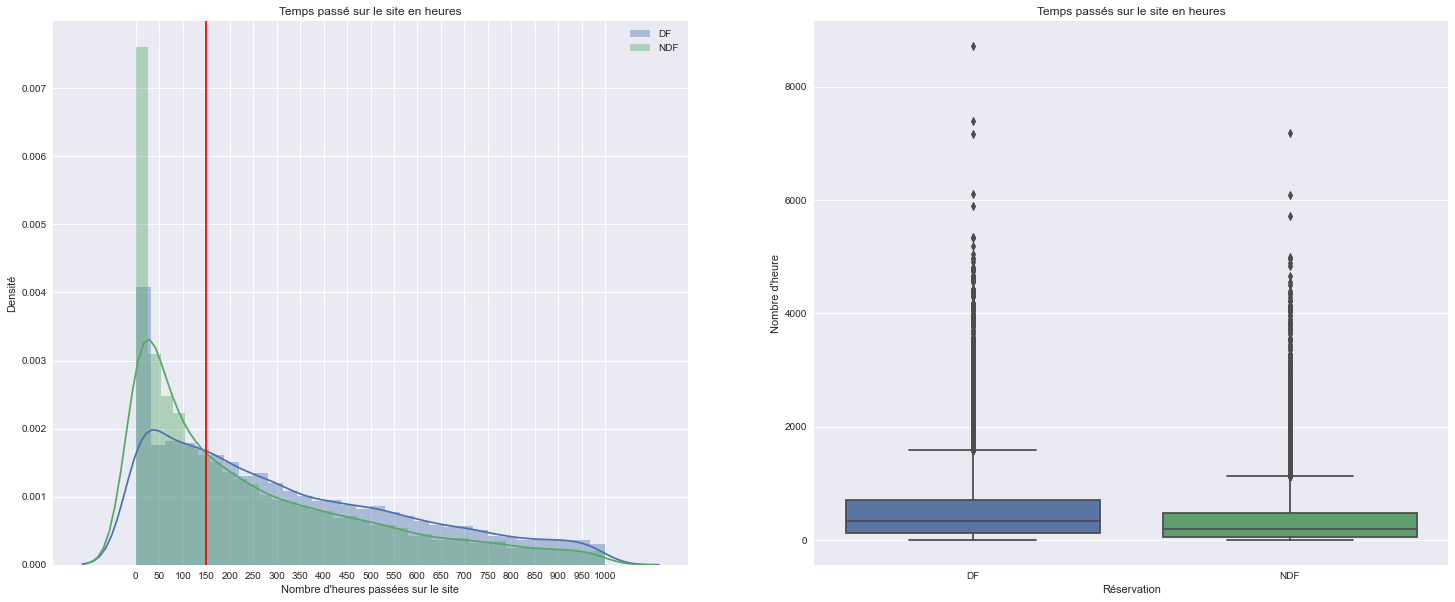

In [114]:
time_elapsed = sessions.groupby(['user_id', 'found_destination'])['secs_elapsed'].sum() / (60**2)
f = plt.figure(figsize=(25, 10))
f.add_subplot(1, 2, 1)
sns.distplot(time_elapsed[time_elapsed < 1000].loc[:,'DF'], label='DF')
sns.distplot(time_elapsed[time_elapsed < 1000].loc[:,'NDF'], label='NDF')
plt.xticks(np.linspace(0, 1000, 21))
plt.axvline(150, 0, 1, color='r')
plt.title("Temps passé sur le site en heures")
plt.xlabel("Nombre d'heures passées sur le site")
plt.ylabel('Densité')
plt.legend()

f.add_subplot(1, 2, 2)
time_elapsed = time_elapsed.reset_index()
sns.boxplot(x="found_destination", y="secs_elapsed", data=time_elapsed) 
plt.xlabel('Réservation')
plt.ylabel("Nombre d'heure")
_ = plt.title("Temps passés sur le site en heures")

* Le nombre d'heures passées en relativement élevé (de l'ordre de la centaine) si on considère que toutes ces activités se sont passées avant la première réservation. C'est pourquoi, il est très probable les activités post-reservations sont également enregistrées.

* Les DF passent beaucoup plus de temps sur le site que les NDF, probablement car ils font l'effort de renseigner leur profil, passer du temps sur les différentes annonces, écrire aux hôtes pour poser des questions, etc. Il est possible qu'une partie des NDF ne font que regarder, mais ce ne sont que des suppositions. 

## La nature des actions effectuées par les utilisateurs

On va étudier les actions effectués par les utilisateurs.

In [115]:
col_names = ['action', 'action_type', 'action_detail']
for col in col_names:
    sessions[col] = sessions[col].fillna('_')
sessions.groupby(col_names).count()['user_id'].describe().round(1)

count       383.0
mean       8086.3
std       32718.1
min           1.0
25%          20.0
50%         243.0
75%        2465.5
max      337312.0
Name: user_id, dtype: float64

* On compte près de 389 actions différentes. 
* Une action a été effectuée plus de 300_000 fois, d'autres qu'une seule fois.

On va récupérer les actions (colonnes "action" + "action_type" + "action_detail") les plus présentes chez les DF puis chez les NDF.

In [116]:
# Concat actions
sessions['action_name'] = sessions['action'] + '-' + sessions['action_type'] + '-' + sessions['action_detail']
sessions.head(3)

,user_id,action,action_type,action_detail,device_type,secs_elapsed,found_destination,country_destination,action_name
0,d1mm9tcy42,lookup,_,_,Windows Desktop,319.0,DF,other,lookup-_-_
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0,DF,other,search_results-click-view_search_results
2,d1mm9tcy42,lookup,_,_,Windows Desktop,301.0,DF,other,lookup-_-_


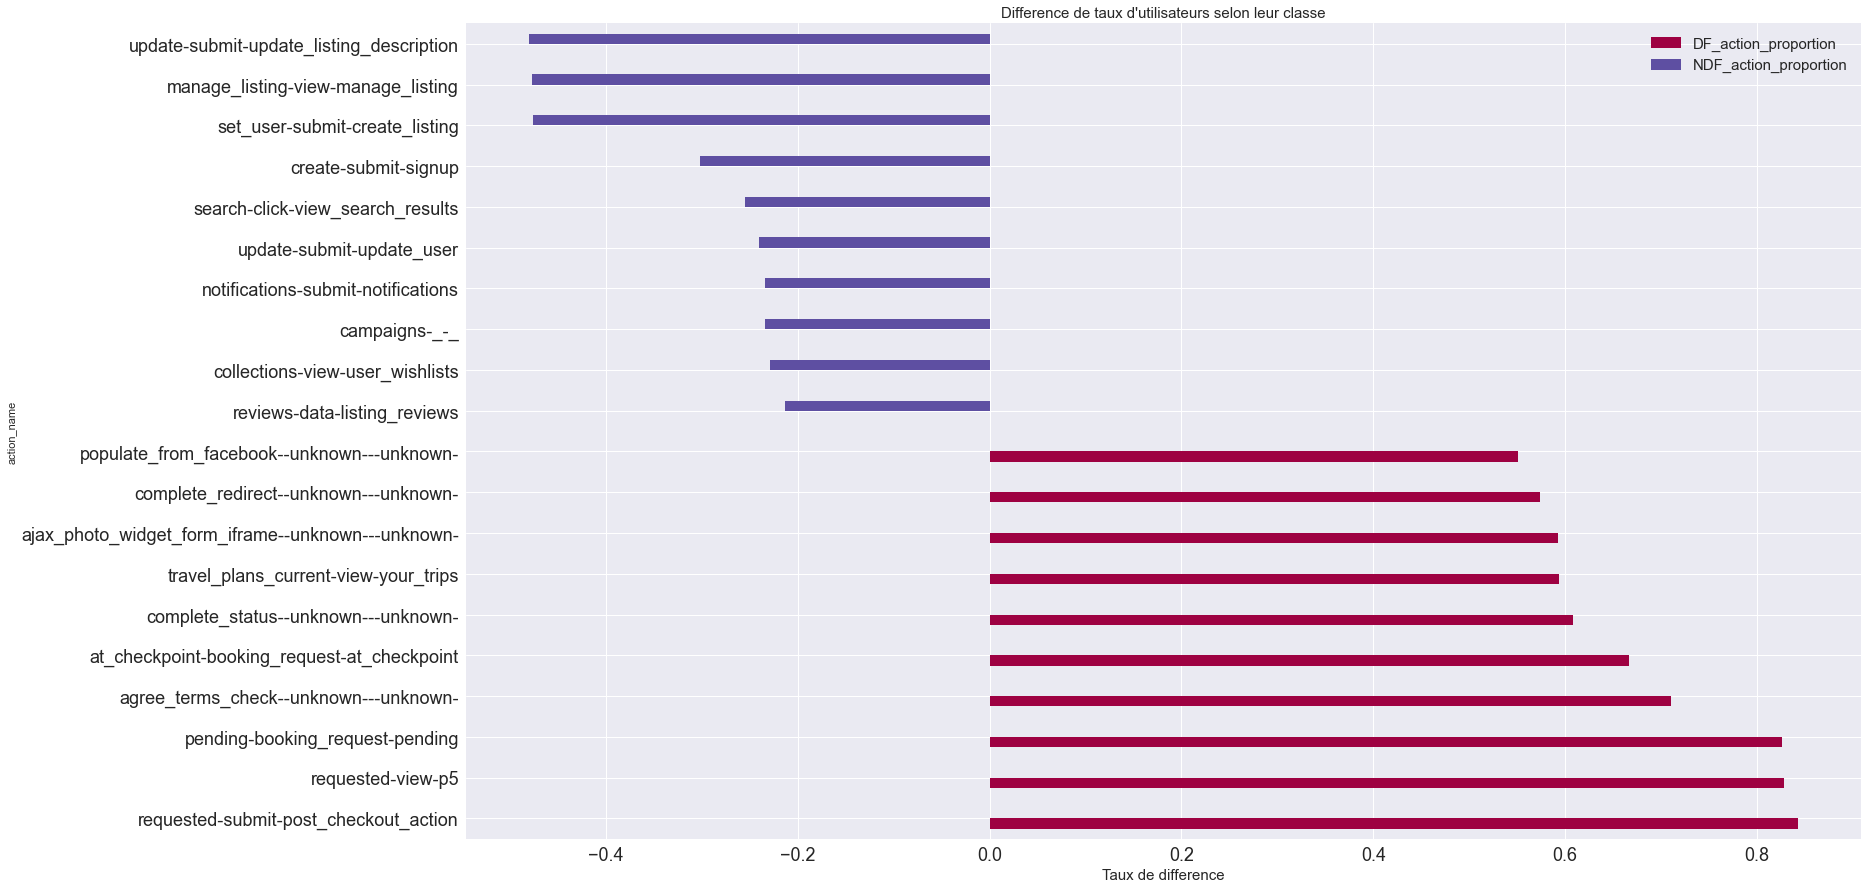

In [117]:
# Count number of users who did a specified action in column 
counts = sessions.groupby(['found_destination', 'action_name']).agg({'user_id': pd.Series.nunique}).rename(columns={'user_id':'count'})

# Separate DF and NDF group
action_names_stats_df = counts.loc['DF'].reset_index().rename({'count': 'count_df'}, axis=1)
action_names_stats_ndf = counts.loc['NDF'].reset_index().rename({'count': 'count_ndf'}, axis=1)

# Merge DataFrame into one
action_names_stats = action_names_stats_df.merge(action_names_stats_ndf, on='action_name', how='outer').fillna(0)
action_names_stats['diff'] = (action_names_stats['count_df'] - action_names_stats['count_ndf']) / (action_names_stats['count_df'] + action_names_stats['count_ndf'])

# Display the most common actions among DF but not among NDF and vice-cersa
n_top = 10
n_actions = 1000  # Threshold of the number of users to reach in order to consider the  action, otherwise it is ignored
ndf_actions_names_stats = action_names_stats[action_names_stats['count_df'] + action_names_stats['count_ndf'] > n_actions].sort_values(by='diff').head(n_top).sort_values(by='diff', ascending=False).reset_index()
df_actions_names_stats = action_names_stats[action_names_stats['count_df'] + action_names_stats['count_ndf'] > n_actions].sort_values(by='diff').tail(n_top).sort_values(by='diff', ascending=False).reset_index()
names_stats = pd.DataFrame({
    'action_name': df_actions_names_stats['action_name'].values.tolist() + ndf_actions_names_stats['action_name'].values.tolist(),
    'DF_action_proportion': df_actions_names_stats['diff'].values.tolist() +  [0 for _ in range(ndf_actions_names_stats.shape[0])],
    'NDF_action_proportion': [0 for _ in range(df_actions_names_stats.shape[0])] + ndf_actions_names_stats['diff'].values.tolist(),
})
ax = names_stats.set_index('action_name').plot.barh(figsize=(25, 15), fontsize=18, colormap='Spectral')
ax.set_title("Difference de taux d'utilisateurs selon leur classe", fontsize=15)
ax.set_xlabel('Taux de difference', fontsize=15)
_ = plt.legend(fontsize=15)

Ici, on vient d'afficher, les 10 actions les plus fréquents chez les NDF et chez les DF en ordonnée. La fréquence d'une action est calculée selon la différence d'apparition chez les DF et les NDF divisée par le nombre total d'apparition au sein des utilisateurs. Plus cette valeur est proche de +1, plus cette action est propre aux DF. Plus cette valeur est proche de -1, plus cette action est propre aux NDF. On ne garde uniquement les actions qui ont été effectuées par au moins 500 utilisateurs.

* On voit sur le graphique que les DF ont une forte tendance à effectuer les actions liées aux réservations : soumettre la requête de réservation ("requested"), mis en attente ("pending"), "agree_terms_check", communiquer avec l'hôte ("message_to_host_change", 'message_to_host_focus")...

* Les actions relatives au terme "listing" renvoient au processus de création ou mise à jour d'une page d'un logement. Ce sont donc des actions liées aux hôtes qui louent leur logement. C'est ce qu'on voit dans les actions les plus effectuées parmi les NDF : "manage_listing" et "set_user-submit-create_listing". Ainsi, une portion des NDF sont des hôtes.

* On atteint des actions avec un taux de difference > 0.8 du côté des DF.

* Du côté des NDF, le taux de différence des actions ne dépassent pas les 0.5.

Affichons le nombre d'utilisateurs qui ont réalisé ces actions.

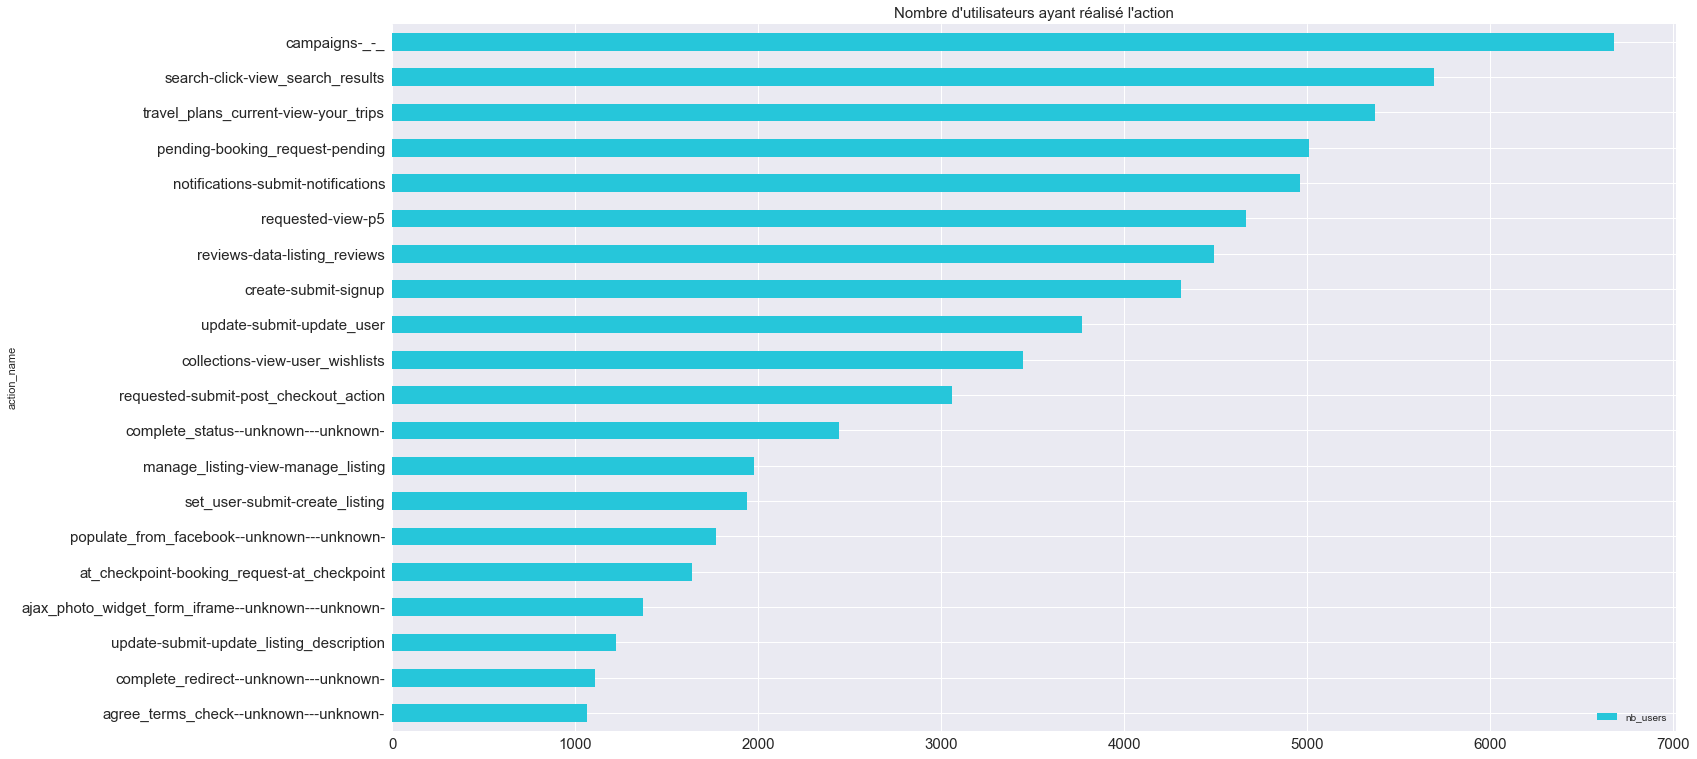

In [118]:
# Have a look at how many users have actually done a specified action found previously
def count_users_who_did(action):
    return sessions[sessions['action_name'] == action]['user_id'].nunique()

actions_names = set(names_stats['action_name'].unique())
names_stats['nb_users'] = names_stats.apply(lambda r: count_users_who_did(r['action_name']), axis=1)
ax = names_stats.sort_values(by='nb_users').plot.barh(x='action_name', y='nb_users', figsize=(23, 13), fontsize=15, color='#26c6da')
_ = ax.set_title("Nombre d'utilisateurs ayant réalisé l'action", fontsize=15)

* Ces actions ne font pas l'unanimité : l'action relevée la plus fréquente ("verify--unknown--unknown-) se retrouve chez 8000 utilisateurs environ (sur les 40000 utilisateurs).
* Certaines actions comme "agree_terms_check--unknown---unknown-" n'ont été réalisées que par 1000 utilisateurs environ.

Tentons de chercher les actions les plus communes pour qu'on augmente la probabilité d'avoir au moins une information sur chaque utilisateur au niveau de son historique d'activités.

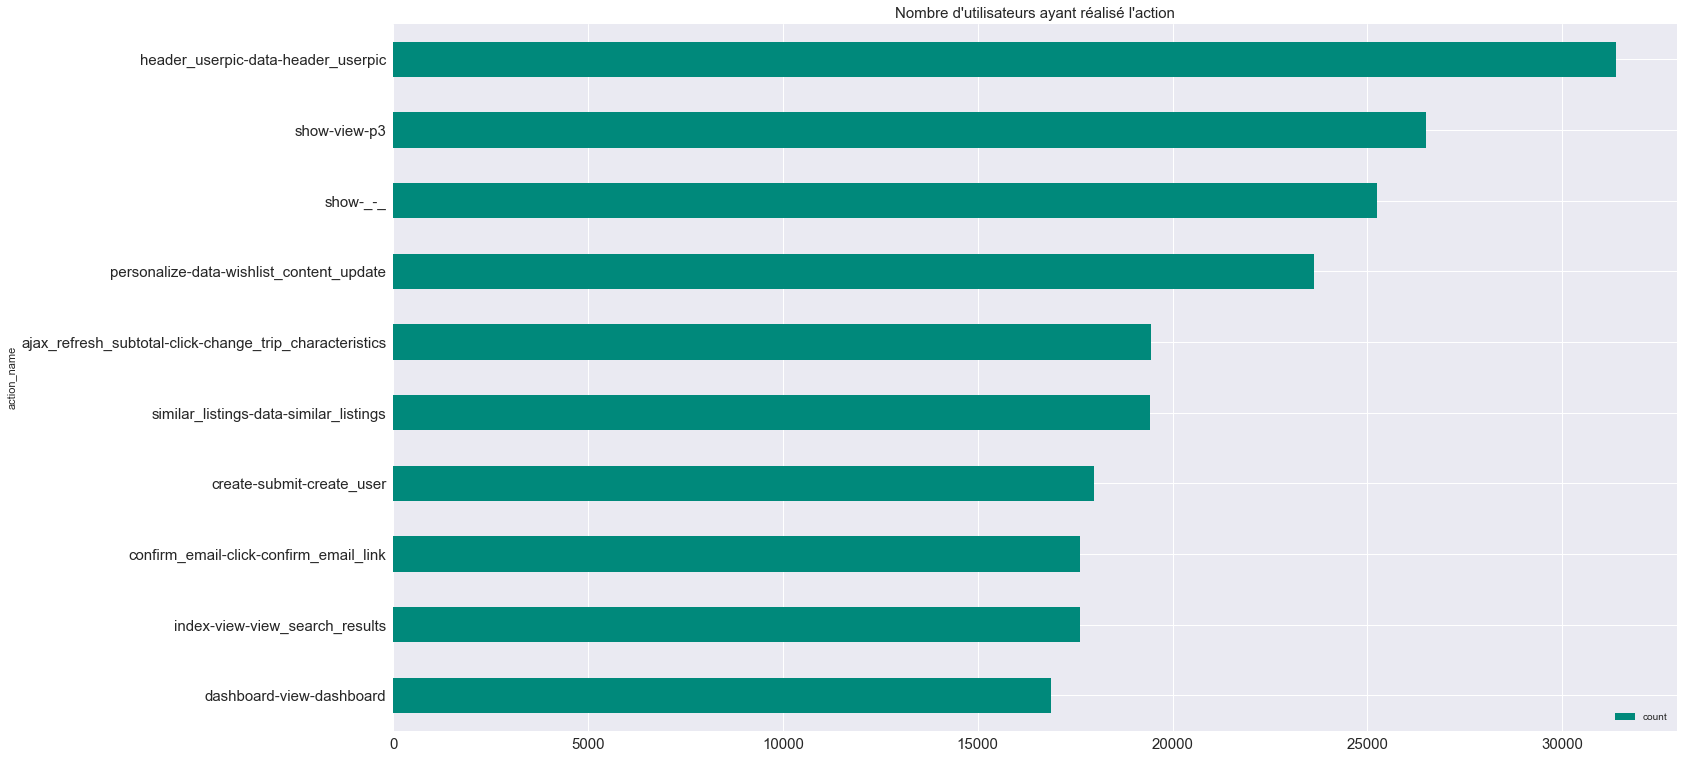

In [119]:
action_names_stats['count'] = action_names_stats['count_df'] + action_names_stats['count_ndf']
action_names_stats.sort_values('count').tail(10).action_name.values.tolist()
ax = action_names_stats.sort_values(by='count').tail(10).plot.barh(x='action_name', y='count', figsize=(23, 13), fontsize=15, color='#00897b')
_ = ax.set_title("Nombre d'utilisateurs ayant réalisé l'action", fontsize=15)

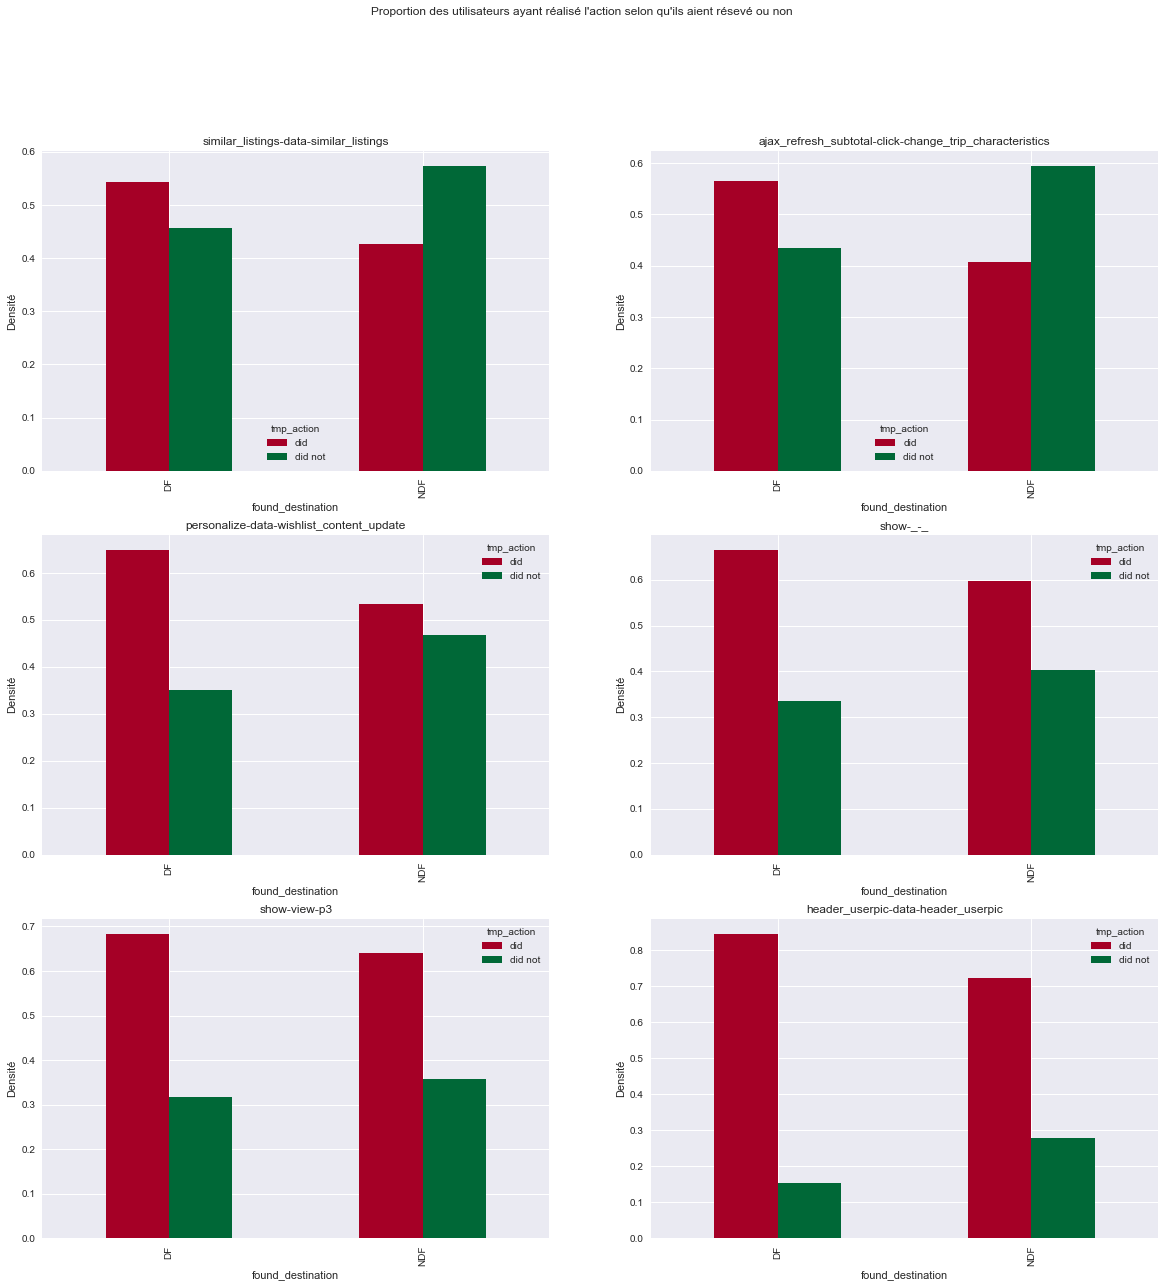

In [120]:
# Retain users that have a session & add information about their session
sessions_naless = sessions.fillna('_')
sessions['action_name'] = sessions_naless['action'] + '-' + sessions_naless['action_type'] + '-' + sessions_naless['action_detail']
users_sessions = sessions.groupby('user_id').agg({
    "action_name": pd.Series.tolist,
    'secs_elapsed': lambda r: round(r.sum() / (60**2), 0),
})
users_sessions = users_sessions.rename({"secs_elapsed":"hours_elapsed", "action_name":"actions",}, axis=1)
users = users_sessions.reset_index().rename({'user_id':'id'}, axis=1).merge(users, how='inner', on='id')

# Prepare and plot users who have done a given action
names = action_names_stats.sort_values(by='count').tail(6)['action_name'].values

fig, axs = plt.subplots(3, 2, figsize=(20, 20))
fig.suptitle("Proportion des utilisateurs ayant réalisé l'action selon qu'ils aient résevé ou non")
for i, (name, ax) in enumerate(zip(names, axs.reshape(-1))):
    users['tmp_action'] = users.apply(lambda r: 'did' if name in r['actions'] else 'did not', axis=1)
    var = pd.crosstab(users['found_destination'], users['tmp_action'])
    var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax, colormap='RdYlGn')
    ax.set_title(name)
    ax.set_ylabel('Densité')

Parmi les actions les plus réalisées :
* 'ajax_refresh_subtotal-click-change_trip_characteristics' est réalisée par 57% des DF contre seulement 40% des NDF.
* Les NDF s'abstiennent de faire l'action 'similar_listings-data-similar_listings', seuls 43% le font contre 55% chez les DF.

On va réaliser le même travail pour les différentes destinations ; à savoir :
* compter le nombre d'utilisateur ayant effectué l'action selon les destinations,
* trier les actions ayant les plus grande disparités, permettant ainsi de séparer les utilisateurs. Pour cela, on va calculer, pour chaque action, l'écart-type entre les destinations,
* selectionner les n actions avec un écart-type maximal.

In [121]:
# We get a DataFrame of actions as index and destination as columns, each value represent the number of
# users who did the action among a specified those who booked in the destination.

# Counting users indexing by destination and action
counts_by_country = sessions.groupby(['country_destination', 'action_name']).agg({'user_id': pd.Series.nunique}).rename(columns={'user_id':'count'})

# Aggregating countings merging and iterating over destinations
action_counts = pd.DataFrame(columns=['action_name'])
for country in users['country_destination'].unique():
    if country == 'NDF': continue  # We don't want NDF
    df_country = counts_by_country.loc[country].rename({'count': f'count_{country}'}, axis=1).reset_index()
    action_counts = action_counts.merge(df_country, how='outer', on='action_name')

action_counts = action_counts.set_index('action_name').fillna(0)
action_counts['std'] = action_counts.div(action_counts.std()).std(axis=1)  # Data are standardized here to compute std !
action_counts.head(3)

,count_US,count_ES,count_DE,count_IT,count_other,count_FR,count_GB,count_CA,count_AU,count_NL,count_PT,std
action_name,,,,,,,,,,,,
10-message_post-message_post,243.0,5.0,1.0,9.0,36.0,6.0,3.0,2.0,1.0,1.0,0.0,0.041854
11-message_post-message_post,59.0,1.0,0.0,3.0,9.0,4.0,0.0,0.0,0.0,0.0,0.0,0.016432
12-message_post-message_post,320.0,6.0,1.0,9.0,27.0,11.0,6.0,4.0,1.0,0.0,0.0,0.054720


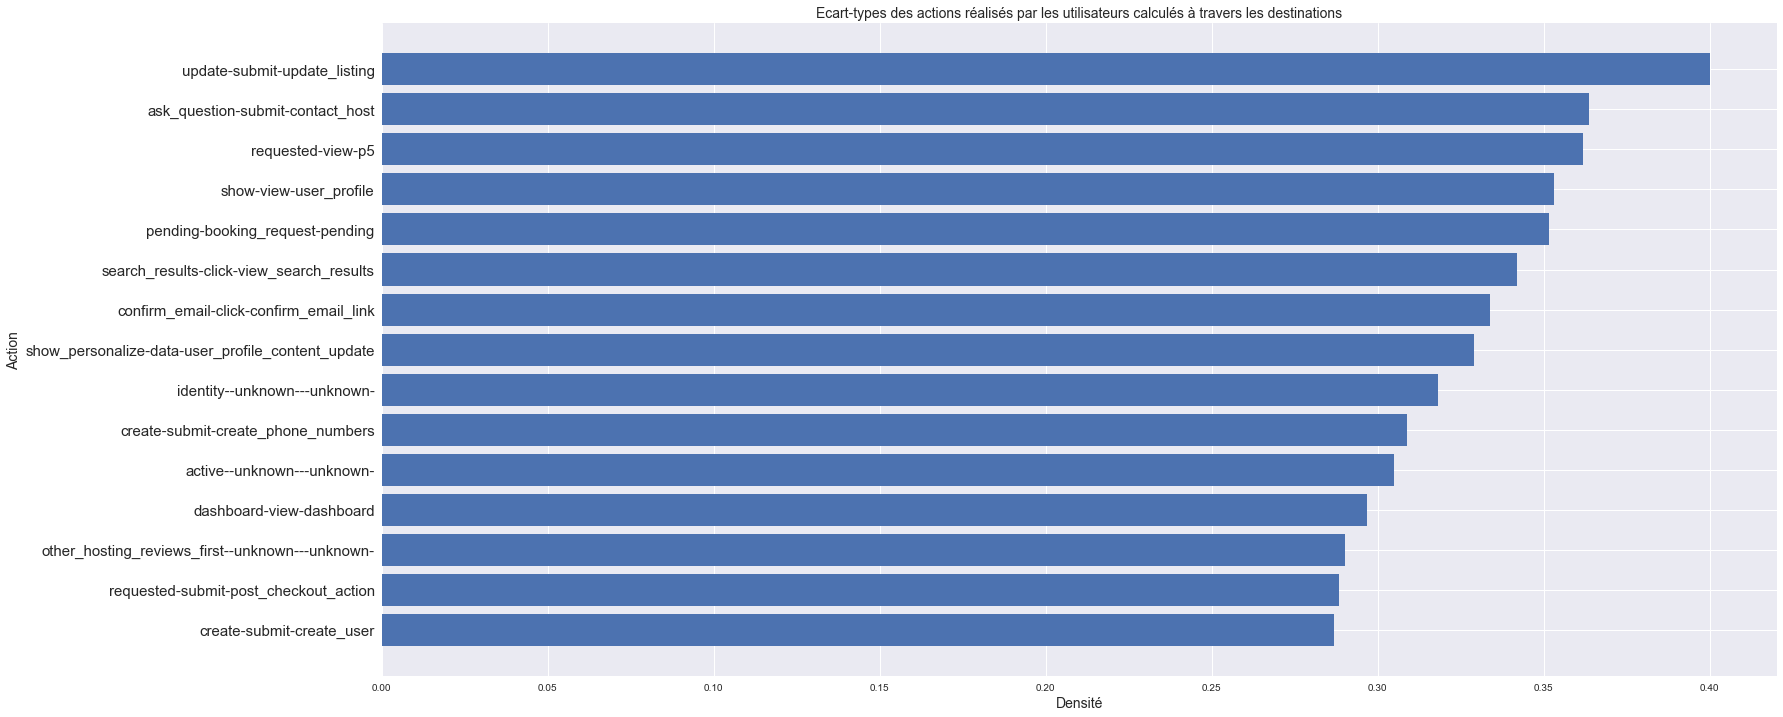

In [122]:
top = action_counts.sort_values('std', ascending=False).head(15).iloc[::-1]
fig, ax = plt.subplots(1, 1, figsize=(25, 12))
ax.barh(top.index, top['std'])
ax.set_yticklabels(top.index, fontsize=15)
ax.set_title("Ecart-types des actions réalisés par les utilisateurs calculés à travers les destinations", fontsize=14)
ax.set_ylabel('Action', fontsize=14)
_ = ax.set_xlabel('Densité', fontsize=14)

On va afficher les proportions d'utilisateurs ayant réalisé une action donnée et ceux qui ne l'ont pas fait selon la destination. On regarde pour les 6 actions ayant le plus grand écart-type.

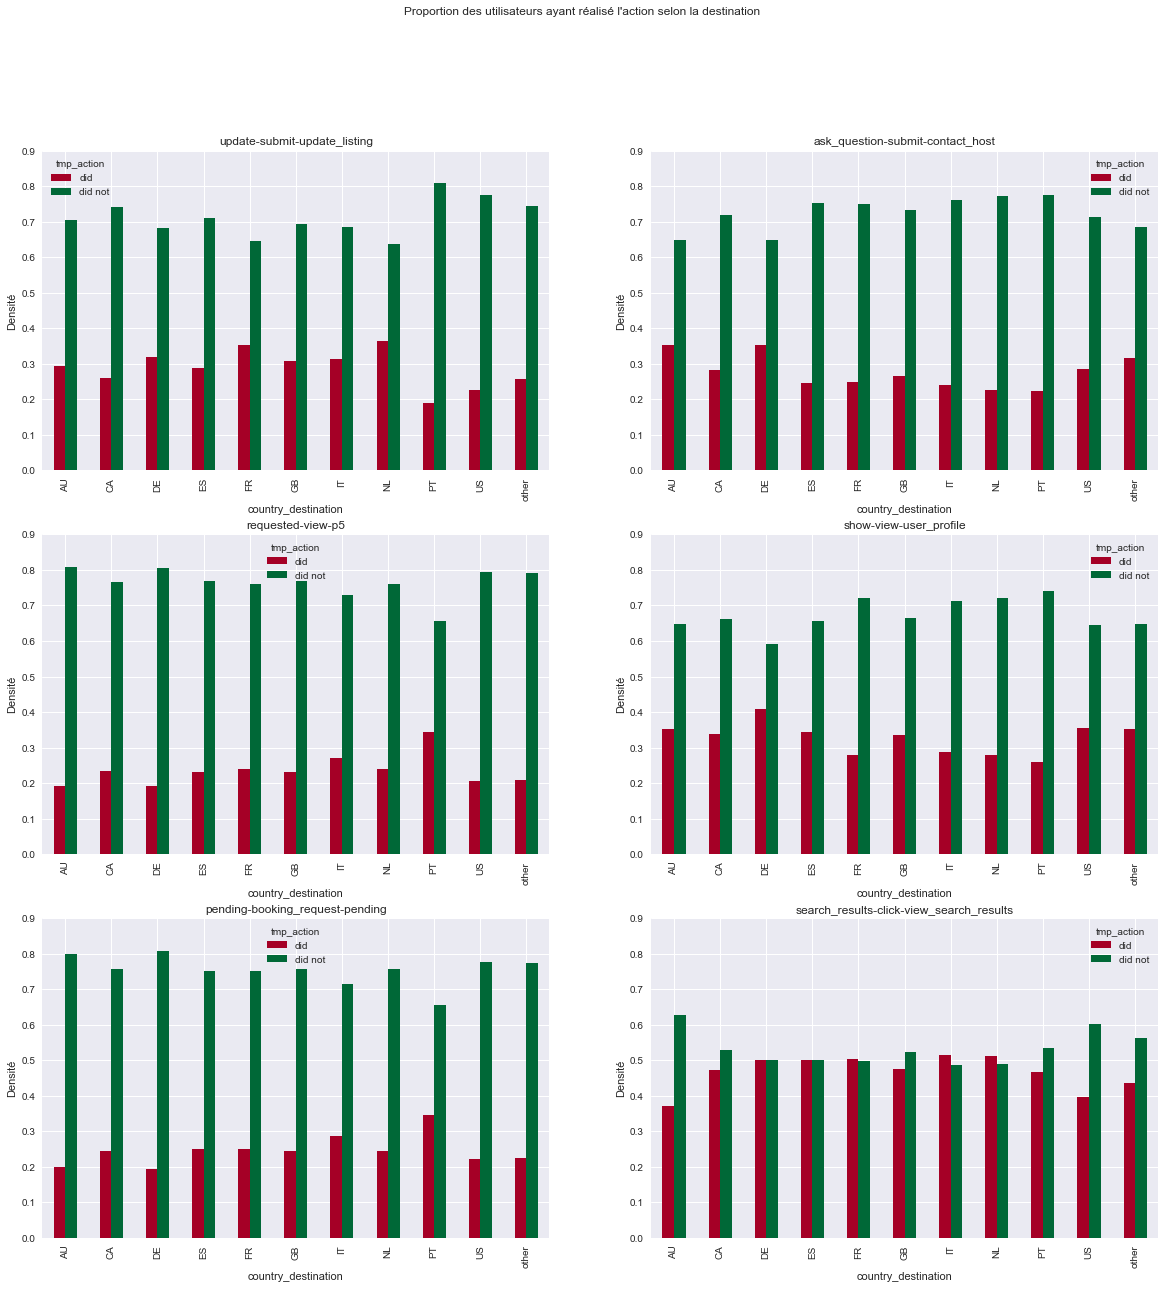

In [123]:
names = action_counts.sort_values('std', ascending=False).head(15).index
fig, axs = plt.subplots(3, 2, figsize=(20, 20))
fig.suptitle("Proportion des utilisateurs ayant réalisé l'action selon la destination")
for i, (name, ax) in enumerate(zip(names, axs.reshape(-1))):
    users['tmp_action'] = users.apply(lambda r: 'did' if name in r['actions'] else 'did not', axis=1)
    var = pd.crosstab(users['country_destination'], users['tmp_action']).drop('NDF')
    var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax, colormap='RdYlGn')
    ax.set_title(name)
    ax.set_yticks(np.arange(0, 1, 0.1))
    ax.set_ylabel('Densité')

Le dernier graphique, avec l'action *search_result-click-view_search_results* est intéressant car on voit que la moitié des populations d'utilisateurs fait cette action pour **les pays européens**. Cette action est moins fréquentes avec les utilisateurs réservant vers d'autres pays hors Europe (US, Australie...).

## L'enchainement des activités

On va regarder si les séquences d'actions réalisées par les utilisateurs permettent de discriminer ceux qui réservent de ceux qui ne réservent pas. Pour cela, on peux s'inspirer des méthodes de **Natural Language Processing (NLP)** puisque la situation est analogue : il s'agit d'étudier une suite item où l'ordre à son importance. Dans notre cas, on va utiliser le **Word2Vec** qui permet de représenter une action (soit un mot en NLP) sous la forme d'un **vecteur de dimensionalité réduite**. Les détails de la méthode sont décrites dans le rapport.

Ici, on encode nos actions en vecteurs de taille 20 (il y a originellement plus de 400 actions différentes) et, pour vérifier la cohérence du modèle **Word2Vec**, on affiche les similarités pour une action.

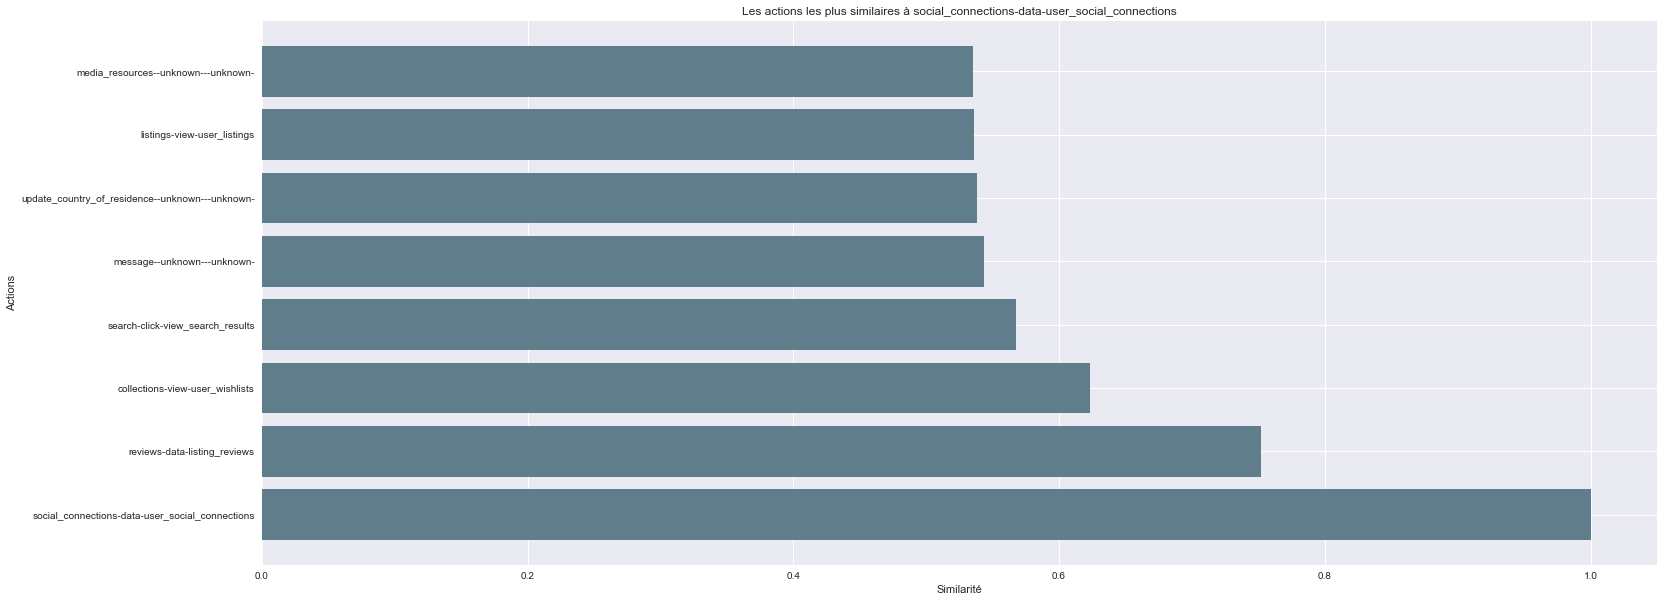

In [124]:
# Actions embedding
import gensim 
from gensim.models import Word2Vec 

users_sess = sessions.groupby('user_id').agg({
    'action_name': pd.Series.tolist, 
    'device_type': lambda x: pd.Series.mode(x)[0], 
    'country_destination': lambda x: pd.Series.mode(x)[0], 
    'found_destination': lambda x: x.iloc[0]}).rename({'action_name': 'actions'}, axis=1)

# Create CBOW model 
size = 20
model = gensim.models.Word2Vec(users_sess['actions'], min_count = 1, size = size, window = 10)

act = 'social_connections-data-user_social_connections'
vector = model.wv[act]
similarity = np.array(model.wv.similar_by_vector(vector, topn=8))
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
ax.set_xlabel('Similarité')
ax.set_ylabel(f'Actions')
ax.set_title(f"Les actions les plus similaires à {act}")
_ = ax.barh(similarity[:,0], similarity[:,1].astype(float), color='#607d8b')

À chaque utilisateur peut être attribué un vecteur représentant la moyenne des vecteurs des actions qu'il a effectué. On utilise **l'ACP** pour afficher les utilisateurs sur 2 dimensions.  

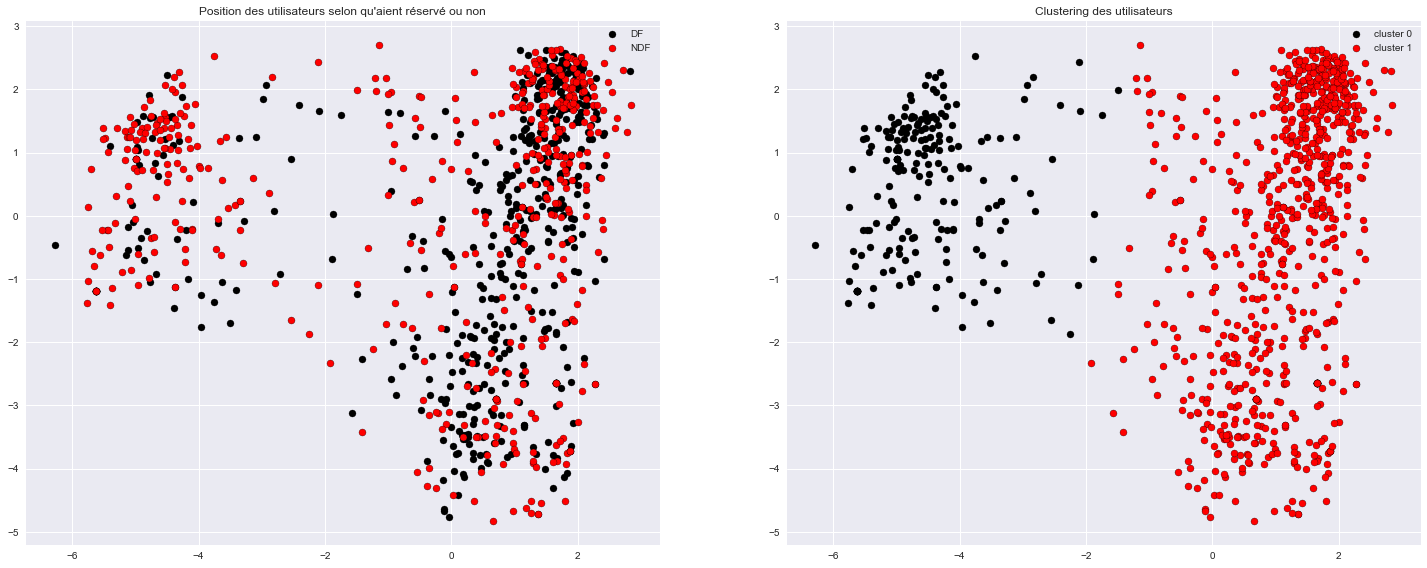

In [125]:
X, y = [], []
for actions, label in zip(users_sess['actions'].values, users_sess['found_destination']):
    v = np.zeros((size, ))
    for action in actions:
        v += model.wv[action]
    X.append(v/len(actions))
    y.append('black' if label == 'DF' else 'red')
X, y = np.array(X), np.array(y)

n = 1000
# Plotting DF vs NDF
twodim = PCA(X)
fig, ax = plt.subplots(1, 2, figsize=(25,10))
for groupid in np.unique(y):
    idx = np.argwhere(groupid == y[:n])
    xx, yy = twodim[:,0], twodim[:,1]
    ax[0].scatter(xx[idx], yy[idx], edgecolors='k', c=groupid, label='DF' if groupid=='black' else 'NDF')
ax[0].set_aspect('equal', 'box')
ax[0].set_title("Position des utilisateurs selon qu'aient réservé ou non")
ax[0].legend()

# Plotting clusters
p = kmeans(twodim, 2, init='kmeans++')
p = np.array(['red' if x == 0 else 'black' for x in p])
for i, groupid in enumerate(np.unique(p)):
    idx = np.argwhere(groupid == p[:n])
    xx, yy = twodim[:,0], twodim[:,1]
    ax[1].scatter(xx[idx], yy[idx], edgecolors='k', c=groupid, label=f'cluster {i}')
    
ax[1].set_aspect('equal', 'box')
ax[1].set_title("Clustering des utilisateurs")
_ = ax[1].legend()

On voit que :
* la méthode du **Word2Vec** a réparti les utilisateurs en 2 clusters ;
* ces 2 clusters ne répresentent pas ceux qui réservent et ceux qui ne réservent pas ;
* le cluster en bas à droite contient plus de NDF que de DF.

On peut tenter de retrouver les 2 groupes d'utilisateurs formés par le Word2Vec. En testant plusieurs variables, c'est le type d'appareil qui correspond le mieux. On affiche, ici, les utilisateurs PC et TELEPHONE sous 2 couleurs différentes.

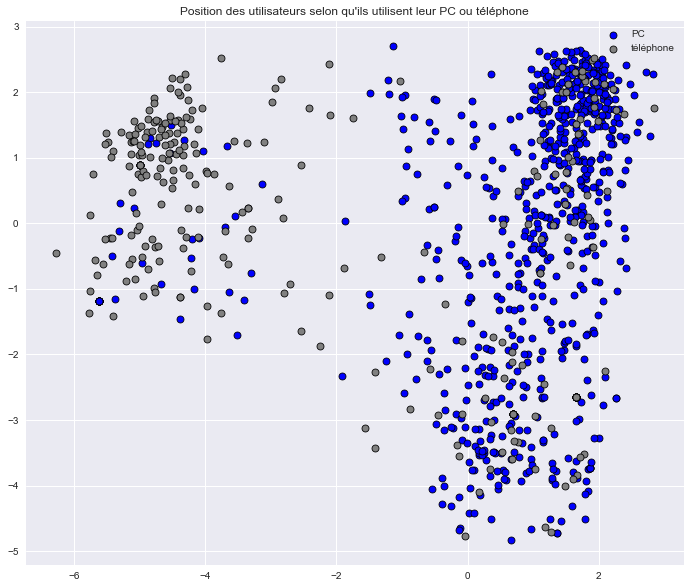

In [126]:
phones = ['iPhone', 'iPad Tablet', 'Android App Unknown Phone/Tablet', 'Android Phone', 'Tablet', 'Chromebook', 'Blackberry',
          'Windows Phone', 'Opera Phone', 'iPodtouch']
pcs = ['Mac Desktop', 'Windows Desktop', 'Linux Desktop']

devices = np.array(['grey' if x in phones else 'blue' for x in users_sess['device_type'].values])

fig, ax = plt.subplots(1, 1, figsize=(25,10))
for groupid in np.unique(devices):
    idx = np.argwhere(groupid == devices[:n])
    xx, yy = twodim[:,0], twodim[:,1]
    ax.scatter(xx[idx], yy[idx], edgecolors='k', linewidth=0.8, c=groupid, label='téléphone' if groupid=='grey' else 'PC')
ax.set_aspect('equal', 'box')
ax.set_title("Position des utilisateurs selon qu'ils utilisent leur PC ou téléphone")
ax.legend()
ax.set_aspect('equal', 'box')

Ainsi, 
* l'enchainement des actions ne fait que séparer les utilisateurs selon le type d'appareil utilisé (PC ou TELEPHONE) et peut donc être résumé par cette catégorisation ;
* les utilisateurs sur téléphone sont plus souvent des NDF.

## Le nombre d'actions effectuées par les utilisateurs

On va dresser le liste des actions réalisées par chaque utilisateur afin d'en exhiber le nombre.

In [127]:
# For each user, make a list of his actions in a DataFrame
action_names = sessions.groupby(['user_id', 'found_destination']).agg({'action_name': pd.Series.tolist}).reset_index()
action_names['number_actions'] = action_names.apply(lambda r: r['action_name'].__len__(), axis=1)
action_names['number_unique_actions'] = action_names.apply(lambda r: set(r['action_name']).__len__(), axis=1)
action_names.head()

,user_id,found_destination,action_name,number_actions,number_unique_actions
0,00023iyk9l,DF,"[index-view-view_search_results, dashboard-vie...",40,15
1,002qnbzfs5,DF,[social_connections-data-user_social_connectio...,789,36
2,005jc3nbmb,NDF,"[recommended_listings--unknown---unknown-, ask...",26,13
3,006mls2sjw,DF,"[personalize-data-wishlist_content_update, sim...",195,27
4,006t3vhawl,DF,"[show-view-p1, ajax_get_referrals_amt--unknown...",27,21


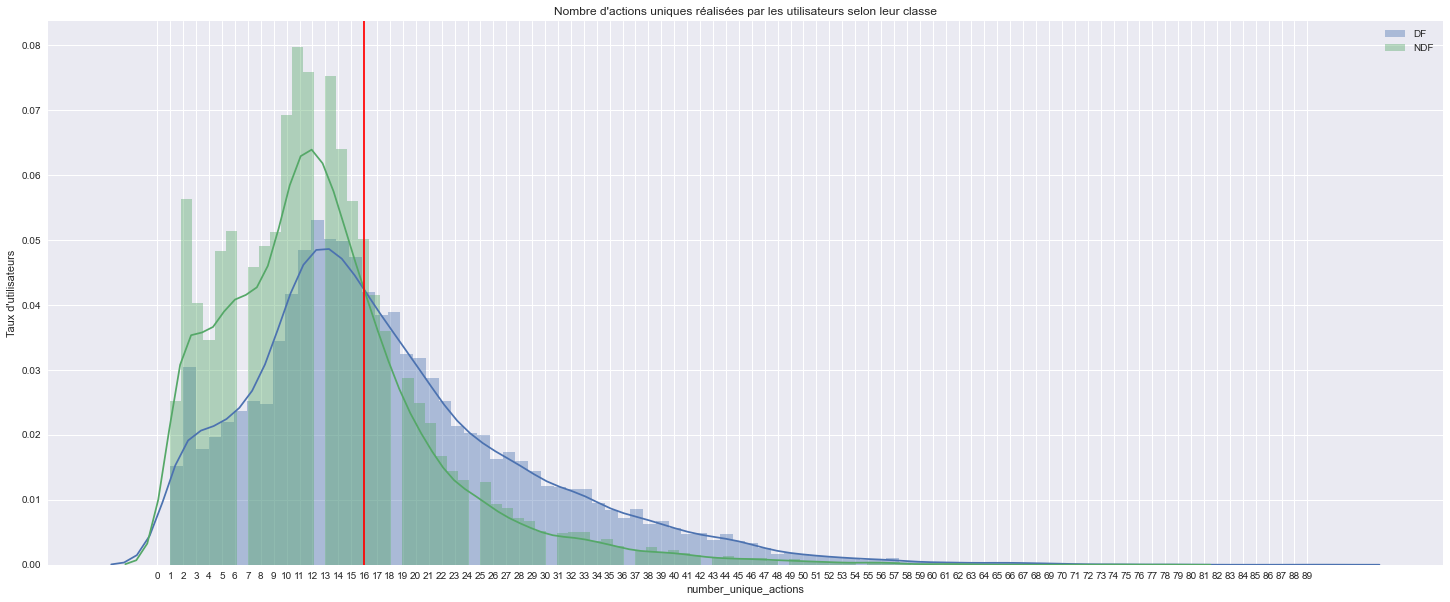

In [128]:
plt.figure(figsize=(25, 10))
n_max = action_names['number_unique_actions'].max()
sns.distplot(action_names[action_names['found_destination'] == 'DF']['number_unique_actions'], bins=n_max, label='DF')
sns.distplot(action_names[action_names['found_destination'] == 'NDF']['number_unique_actions'], bins=n_max, label='NDF')
plt.axvline(16, 0, 1, color='r')
plt.xticks(range(n_max))
plt.ylabel("Taux d'utilisateurs")
plt.legend()
_ = plt.title("Nombre d'actions uniques réalisées par les utilisateurs selon leur classe")

* Le nombre d'actions uniques chez les NDF est généralement moindre que chez les DF.
* On voit une séparation où la densité est plus forte du côté des NDF en-dessous de 16 actions différentes et une densité plus forte du côté des DF après cette valeur. 

## Le type d'appareil utilisé

On va étudier la variable "device_type".

In [129]:
train_users = pd.read_csv('./data/train_users_2.csv')
devices = sessions.groupby('user_id').agg({'found_destination': lambda r: r.iloc[0],
                                'country_destination': lambda r: r.iloc[0],
                                'secs_elapsed': lambda r: round(r.sum() / (60**2), 0),
                                'device_type': lambda r: r.values.tolist(),
                                'action_name': lambda r: r.shape[0],})

devices = devices.rename({'action_name': 'nb_actions', 'secs_elapsed': 'hours_elapsed'}, axis=1)
for device_type in sessions['device_type'].unique():
    devices[device_type + '_count'] = devices.apply(lambda r: r['device_type'].count(device_type), axis=1)    

users_as_id = train_users.set_index('id')
devices['first_device_type'] = devices.apply(lambda r: users_as_id.loc[r.name]['first_device_type'], axis=1)
devices['device_type'] = devices.apply(lambda r: set(r['device_type']), axis=1)
devices['nb_devices'] = devices.apply(lambda r: len(r['device_type']), axis=1)
devices.head(3)

,found_destination,country_destination,hours_elapsed,device_type,nb_actions,Windows Desktop_count,-unknown-_count,iPhone_count,iPad Tablet_count,Mac Desktop_count,...,Linux Desktop_count,Android Phone_count,Chromebook_count,Tablet_count,Windows Phone_count,Blackberry_count,Opera Phone_count,iPodtouch_count,first_device_type,nb_devices
user_id,,,,,,,,,,,,,,,,,,,,,
00023iyk9l,DF,US,241.0,"{Mac Desktop, iPhone}",40,0,0,4,0,36,...,0,0,0,0,0,0,0,0,Mac Desktop,2
002qnbzfs5,DF,US,1802.0,"{-unknown-, iPhone}",789,0,14,775,0,0,...,0,0,0,0,0,0,0,0,iPhone,2
005jc3nbmb,NDF,NDF,776.0,"{iPhone, Windows Desktop}",26,1,0,25,0,0,...,0,0,0,0,0,0,0,0,iPhone,2


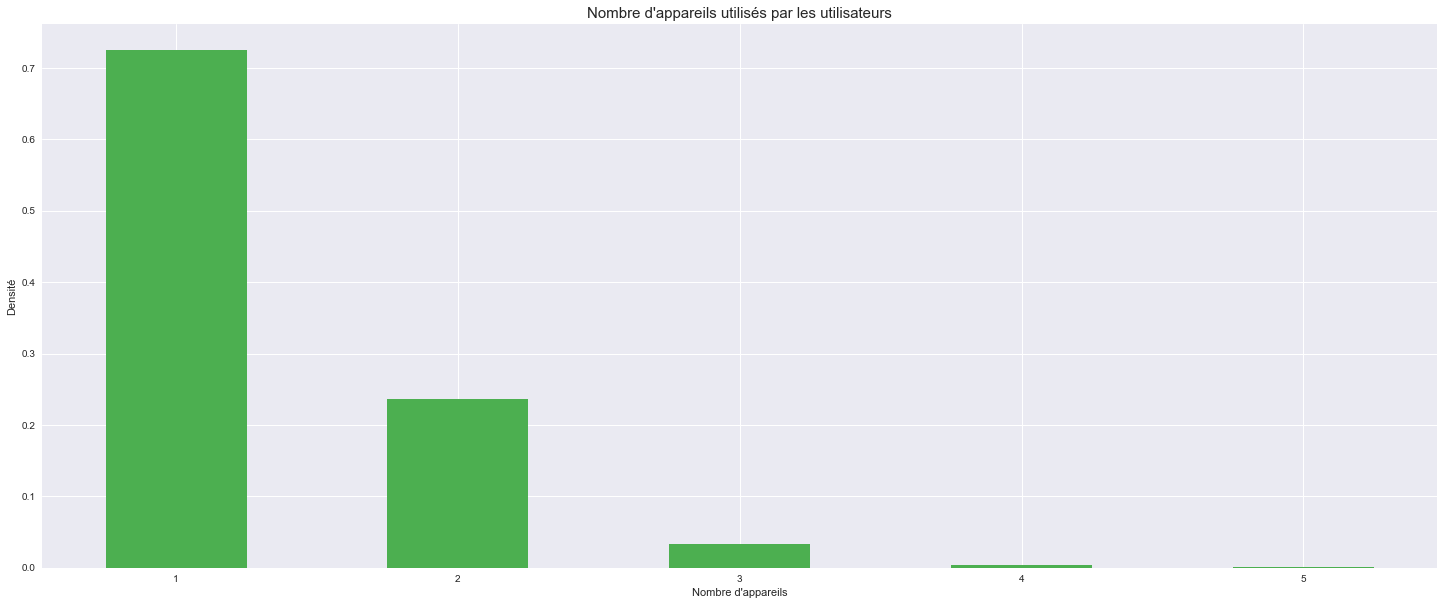

In [130]:
ax = devices['nb_devices'].hist(bins=np.arange(6)+0.5, figsize=(25, 10), rwidth=0.5, density=True, color='#4caf50')
ax.set_title("Nombre d'appareils utilisés par les utilisateurs", fontsize=15)
ax.set_xlabel("Nombre d'appareils")
_ = ax.set_ylabel('Densité')

* Plus de 70% des utilisateurs n'utilisent qu'un seul appareil.
* Seul 25% des utilisateurs en utilisent deux.

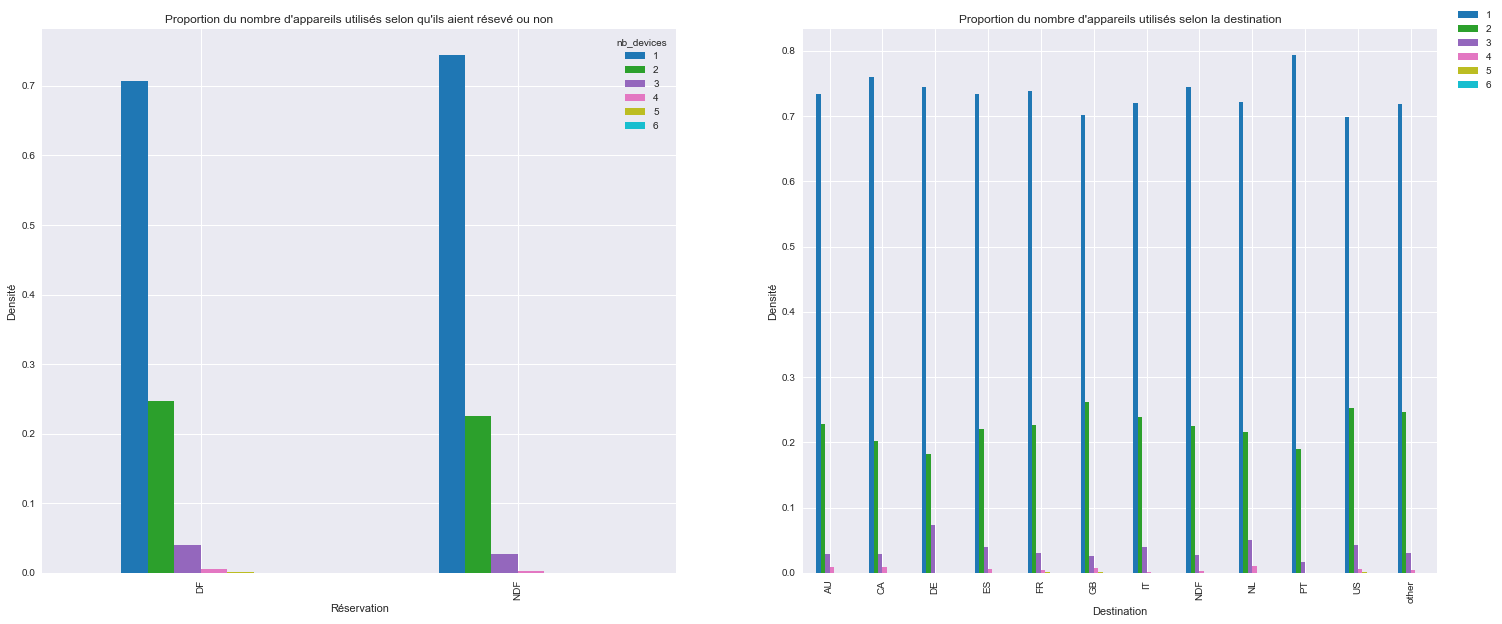

In [131]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
var = pd.crosstab(devices['found_destination'], devices['nb_devices'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax1, colormap='tab10')
ax1.set_title("Proportion du nombre d'appareils utilisés selon qu'ils aient résevé ou non")
ax1.set_ylabel("Densité")
ax1.set_xlabel('Réservation')

var = pd.crosstab(devices['country_destination'], devices['nb_devices'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax2, colormap='tab10')
plt.legend(bbox_to_anchor=(1.1, 1.05))
ax2.set_ylabel("Densité")
ax2.set_xlabel('Destination')
_ = ax2.set_title("Proportion du nombre d'appareils utilisés selon la destination")

Les résultats ne permettent pas de séparer les individus. On voit tout de même que :
* 80% des utilisateurs réservant au Portugal _PT_ n'utilise qu'un seul appareil,
* 25% des utilisateurs réservant en Australie _AU_ ou aux Etats-Unis _US_ utilisent deux appareils.

On va regarder les types d'appareils utilisés (smartphone ou ordinateur) par les utilisateurs. On va leur attribuer une valeur selon qu'il ait utilisé un téléphone, un ordinateur, les deux ou bien des appareils non reconnus.

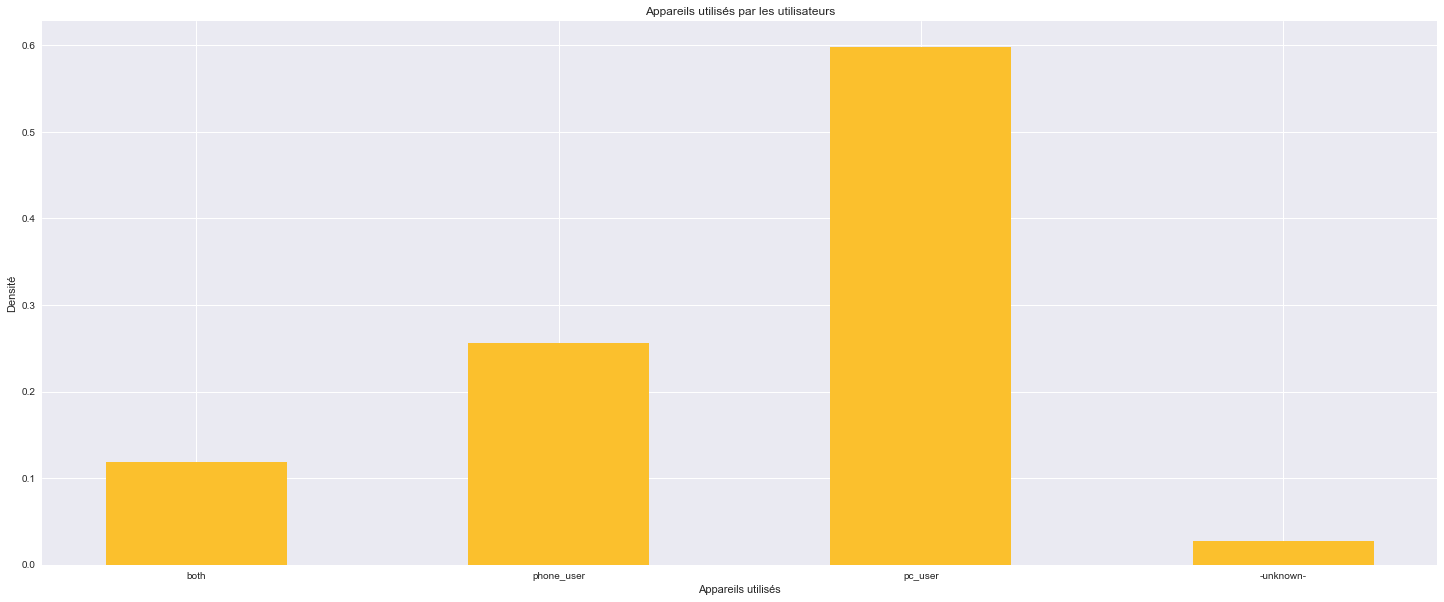

In [132]:
phones = ['iPhone', 'iPad Tablet', 'Android App Unknown Phone/Tablet', 'Android Phone', 'Tablet', 'Chromebook', 'Blackberry',
          'Windows Phone', 'iPodtouch']
pcs = ['Mac Desktop', 'Windows Desktop', 'Linux Desktop']

def devices2group(device_set):
    if len(device_set.intersection(phones)) > 0 and len(device_set.intersection(pcs)) > 0:
        return 'both'
    elif len(device_set.intersection(phones)) > 0:
        return 'phone_user'
    elif len(device_set.intersection(pcs)) > 0:
        return 'pc_user'
    else:
        return '-unknown-'
        
devices['device_group'] = devices.apply(lambda r: devices2group(r['device_type']), axis=1)
ax = devices['device_group'].hist(bins=np.arange(5)-0.5, figsize=(25, 10), rwidth=0.5, density=True, color='#fbc02d')
ax.set_title("Appareils utilisés par les utilisateurs")
ax.set_xlabel("Appareils utilisés")
_ = ax.set_ylabel('Densité')

* 60% des individus utilisent un ordinateur contre 25% environ d'utilisateur de téléphone. 
* Environ 12% utilisent tout de même les deux.

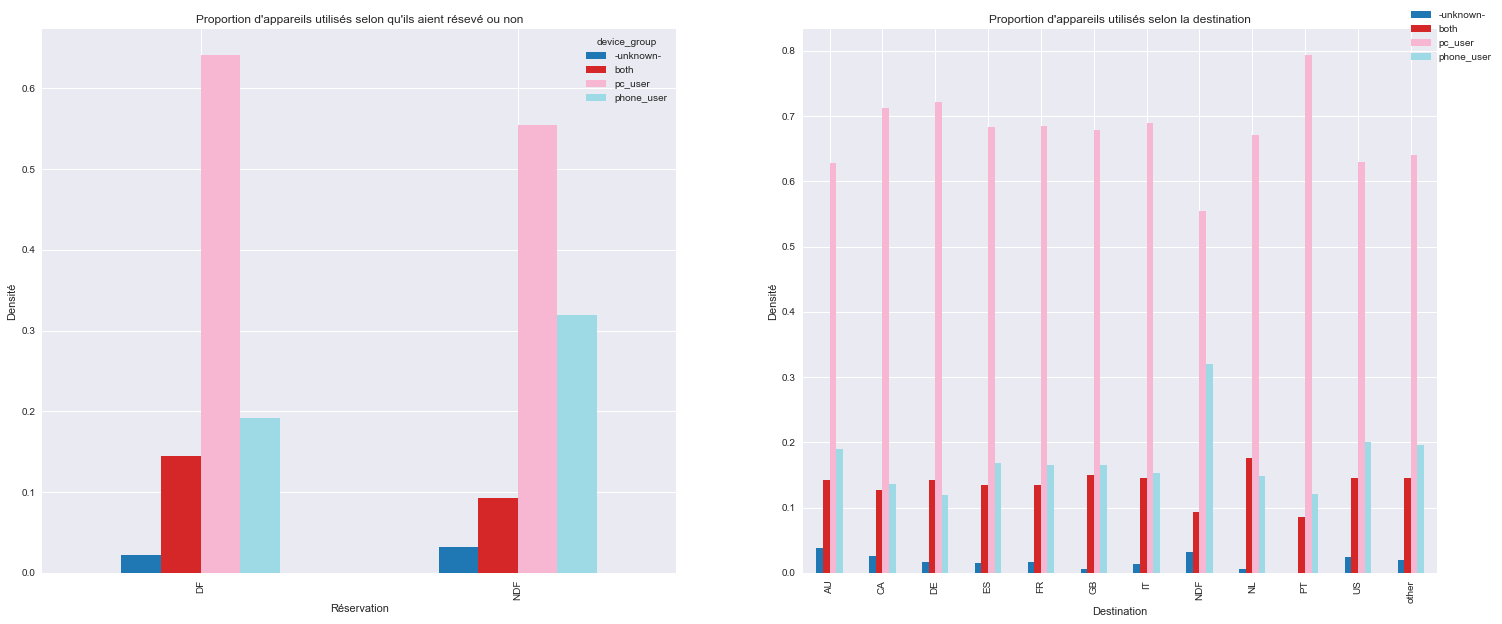

In [133]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
var = pd.crosstab(devices['found_destination'], devices['device_group'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax1, colormap='tab20')
ax1.set_title("Proportion d'appareils utilisés selon qu'ils aient résevé ou non")
ax1.set_ylabel("Densité")
ax1.set_xlabel('Réservation')

var = pd.crosstab(devices['country_destination'], devices['device_group'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax2, colormap='tab20')
plt.legend(bbox_to_anchor=(1.1, 1.05))
ax2.set_ylabel("Densité")
ax2.set_xlabel('Destination')
_ = ax2.set_title("Proportion d'appareils utilisés selon la destination")

Cette information permet de remarquer que les NDF ont une plus grande utilisation du téléphone (32%) tandis que les DF ont une part plus importante d'utilisateur d'ordinateur (63%). On peut tenter de redistribuer les individus qui utilisent les deux types d'appareils en regardant la nature de l'appareil de plus utilisé par l'individu. Les résultats sont affichés ci-dessous.

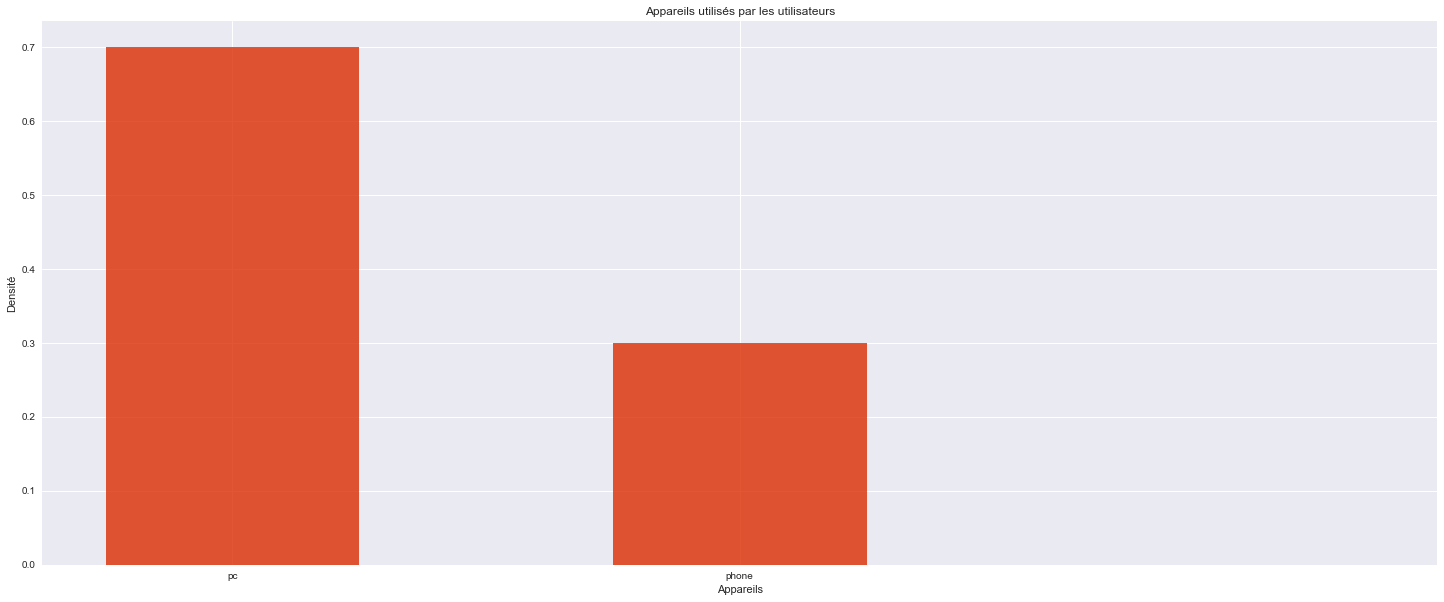

In [134]:
devices_names = []
devices_names += [name+'_count' for name in phones]
devices_names += [name+'_count' for name in pcs]
devices['most_use'] = devices[devices_names].apply(lambda r: r.astype(int).idxmax(), axis=1)

def most_use2group(most_use):
    exp = most_use.split('_count')[0]  # Remove _count suffix
    if exp in phones:
        return 'phone'
    elif exp in pcs:
        return 'pc'
    else:
        return '-unknown-'
    
devices['most_use_group'] = devices.apply(lambda r: most_use2group(r['most_use']), axis=1)
ax = devices['most_use_group'].hist(bins=np.arange(4)-0.5, figsize=(25, 10), rwidth=0.5, density=True, color='#dd2c00', alpha=0.8)
ax.set_title("Appareils utilisés par les utilisateurs")
ax.set_xlabel('Appareils')
_ = ax.set_ylabel('Densité')

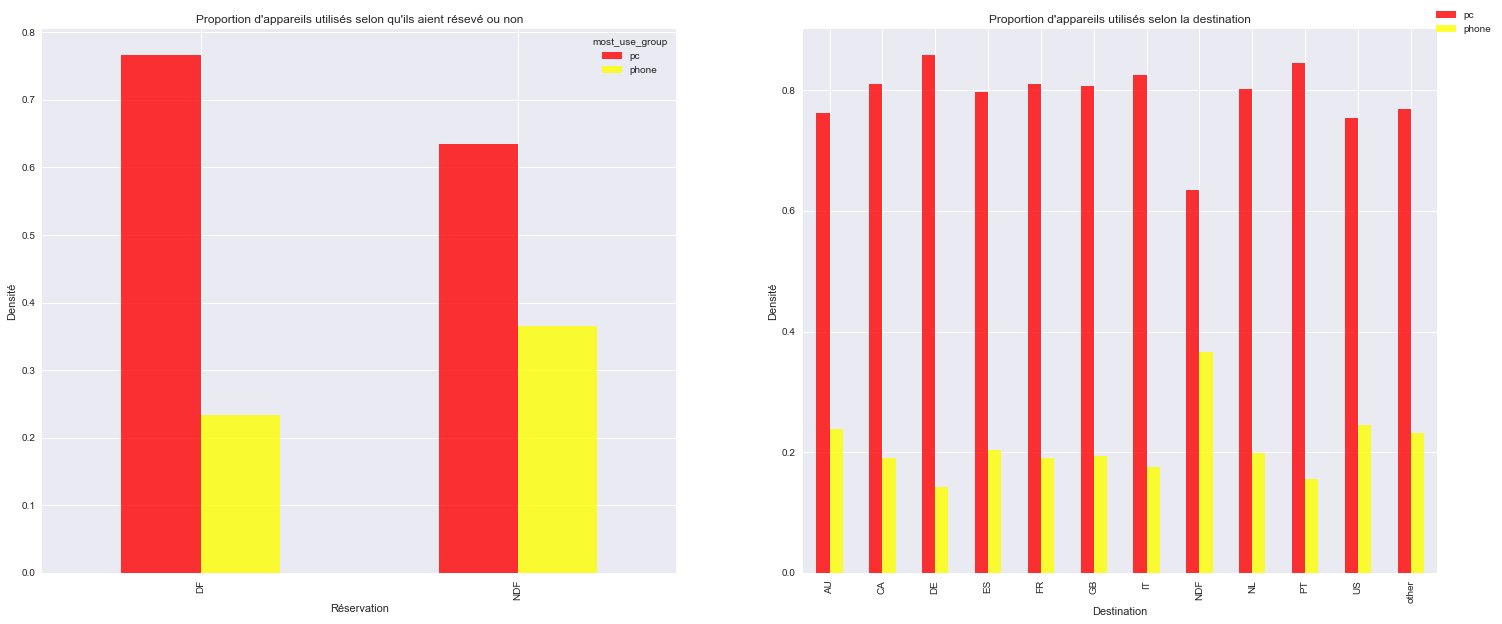

In [135]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
var = pd.crosstab(devices['found_destination'], devices['most_use_group'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax1, colormap='autumn', alpha=0.8)
ax1.set_title("Proportion d'appareils utilisés selon qu'ils aient résevé ou non")
ax1.set_ylabel("Densité")
ax1.set_xlabel('Réservation')

var = pd.crosstab(devices['country_destination'], devices['most_use_group'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax2, colormap='autumn', alpha=0.8)
plt.legend(bbox_to_anchor=(1.1, 1.05))
ax2.set_ylabel("Densité")
ax2.set_xlabel('Destination')
_ = ax2.set_title("Proportion d'appareils utilisés selon la destination")

* Parmi les DF, 75% des individus utilisent l'ordinateur contre seulement 20% pour le téléphone. 
* Parmi les NDF, 63% utilisent l'ordinateur tandis que 30% utilisent le téléphone.